In [2]:
import numpy as np

import scipy as sp
import scipy.cluster

import itertools
import pickle
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from utils.fooof_utils import get_foofed_spectrum, get_foof_model
from utils.colors import okabe, CB_color_cycle, ripples_blue, noise_color, ripples_orange
from utils.clusters import compute_surr_gain
from utils.pac import transform_to_cdf

from joblib import Parallel, delayed

import seaborn as sns

d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
%config InlineBackend.figure_format = 'jpg'

In [4]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe)
sp.cluster.hierarchy.set_link_color_palette(CB_color_cycle)

In [5]:
submission_data_path = os.path.join('..', '..', 'meso_submission_data')

lags_cycles = np.arange(200)/10

example_pac = pickle.load(open(os.path.join(submission_data_path, 'figure_2', 'example_subject'), 'rb'))
f_vals = example_pac['f_vals']

all_noise_lengths = np.load(os.path.join(submission_data_path, 'SEEG', 'noise_pacf_freqwise.npy'))

noise_level = np.load(os.path.join(submission_data_path, 'figure_2', 'noise_level.npy'))
noise_mean = np.load(os.path.join(submission_data_path, 'figure_2', 'noise_mean.npy'))

subject_to_plot = np.load(os.path.join(submission_data_path, 'figure_2', 'target_subject.npy'))

In [6]:
fidx = 16*2

long_pac_idx = (subject_to_plot[fidx] >= 5)

data_avg_pac = example_pac['data_pac'][fidx].mean(axis=0)
data_std_pac = example_pac['data_pac'][fidx].std(axis=0)

long_avg_pac = example_pac['data_pac'][fidx][long_pac_idx].mean(axis=0)
short_avg_pac = example_pac['data_pac'][fidx][~long_pac_idx].mean(axis=0)

pac_percentile_25, pac_percentile_75 = np.percentile(example_pac['data_pac'][fidx], (25,75), axis=0)

long_percentile_25, long_percentile_75 = np.percentile(example_pac['data_pac'][fidx][long_pac_idx], (25,75), axis=0)
short_percentile_25, short_percentile_75 = np.percentile(example_pac['data_pac'][fidx][~long_pac_idx], (25,75), axis=0)

noise_avg_pac = example_pac['noise_pac'][fidx].mean(axis=0)
noise_std_pac = example_pac['noise_pac'][fidx].std(axis=0)

data_pac_cdfs = np.apply_along_axis(transform_to_cdf, 1, example_pac['data_pac'][fidx])
noise_pac_cdfs = np.apply_along_axis(transform_to_cdf, 1, example_pac['noise_pac'][fidx])

cdf_avg = data_pac_cdfs.mean(axis=0)
cdf_std = data_pac_cdfs.std(axis=0)

noise_cdf_avg = noise_pac_cdfs.mean(axis=0)
noise_cdf_std = noise_pac_cdfs.std(axis=0)

### CDF

long_cdf_avg = data_pac_cdfs[long_pac_idx].mean(axis=0)
short_cdf_avg = data_pac_cdfs[~long_pac_idx].mean(axis=0)

long_cdf_p_25, long_cdf_p_75 = np.percentile(data_pac_cdfs[long_pac_idx], (5,95), axis=0)
short_cdf_p_25, short_cdf_p_75 = np.percentile(data_pac_cdfs[~long_pac_idx], (5,95), axis=0)

avg_pac_len = subject_to_plot[fidx].mean()
std_pac_len = subject_to_plot[fidx].std()

noise_avg_pac_len = noise_mean[fidx]

cdf_percentile_25, cdf_percentile_75 = np.percentile(data_pac_cdfs, (25,75), axis=0)

In [7]:
fig_data_path = os.path.join(submission_data_path, 'figure_2', 'figure_psd_data.pickle')
fig_2_data = pickle.load(open(fig_data_path, 'rb'))
pxxf, subj_psds = fig_2_data['pxxf'], fig_2_data['subj_psds']

In [8]:
freq_mask = (pxxf >= 2) & (pxxf <= 48) | (pxxf >= 52) & (pxxf <= 98)
fooof_pxxf = pxxf[(pxxf >= 2) & (pxxf <= 98)]
spectrum_mask = pxxf[(pxxf >= 2) & (pxxf <= 98)]
spectrum_mask = ((spectrum_mask <= 48) | (spectrum_mask >= 52))

fooofed_spectrums = np.array(Parallel(n_jobs=32)(delayed(get_foofed_spectrum)(pxxf, spectrum) for spectrum in subj_psds))
fooofed_models = Parallel(n_jobs=32)(delayed(get_foof_model)(pxxf, spectrum) for spectrum in subj_psds)

foof_to_pac_idx = np.abs(fooof_pxxf.reshape(1,-1) - f_vals.reshape(-1,1)).argmin(axis=-1)


In [9]:
foof_spectra_flat = np.array([mdl.fooofed_spectrum_[foof_to_pac_idx] for mdl in fooofed_models])
M_psds = sp.cluster.hierarchy.linkage(foof_spectra_flat, method='ward')

M_pacs = sp.cluster.hierarchy.linkage(subject_to_plot.T, method='ward')

labels_pacs = sp.cluster.hierarchy.fcluster(M_pacs, t=4, criterion='maxclust') - 1

n_clusts = len(set(labels_pacs))

labels_pacs_ok = labels_pacs.copy()
labels_pacs_ok[labels_pacs == 2] = 1
labels_pacs_ok[labels_pacs == 1] = 2

labels_pacs = labels_pacs_ok.copy()

d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\vlamyr\AppData\Local\Temp\4\ipykernel_31096\3875058891.py:223: UserWarning: This figure includes Axes that are

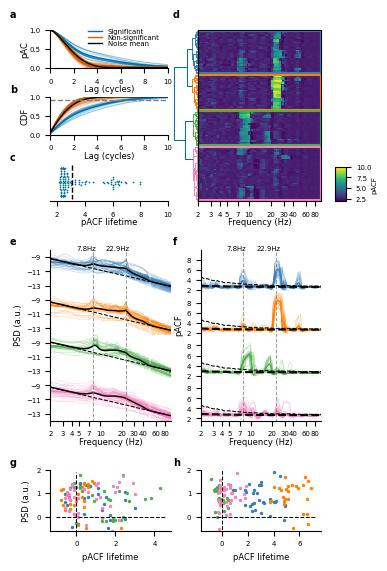

In [10]:
ts = np.arange(10000)/1000

nrows = 10
ncols = 9

fig = plt.figure(figsize=(3.5, 6.5))

gs_main = fig.add_gridspec(nrows, ncols, hspace=8)

gs1 = gs_main[:4, :4].subgridspec(3, 1, hspace=0.75, wspace=0.0)
gs2 = gs_main[:4, 4:].subgridspec(1, 2, wspace=0.0, width_ratios=[1,5])
gs3 = gs_main[4:8, :].subgridspec(4, 2, hspace=0.0, wspace=0.25)
gs4 = gs_main[8:, :].subgridspec(1, 2, wspace=0.25)

ax1 = fig.add_subplot(gs1[0])
ax9 = fig.add_subplot(gs1[1])
ax7 = fig.add_subplot(gs1[2])

ax10 = fig.add_subplot(gs2[0])
ax2 = fig.add_subplot(gs2[1])

ax11 = fig.add_subplot(gs4[0])
ax12 = fig.add_subplot(gs4[1])

axes_clusters = [fig.add_subplot(gs3[i, 1]) for i in range(n_clusts)]
axes_psd_clusters = [fig.add_subplot(gs3[i, 0]) for i in range(n_clusts)]

ax1.plot(lags_cycles, long_avg_pac, lw=1, color=ripples_blue, label='Significant')
ax1.plot(lags_cycles, example_pac['data_pac'][fidx][long_pac_idx].T, color=ripples_blue, lw=0.5, alpha=0.25)

ax1.plot(lags_cycles, short_avg_pac, lw=1, color=ripples_orange, label='Non-significant')
ax1.plot(lags_cycles, example_pac['data_pac'][fidx][~long_pac_idx].T, color=ripples_orange, lw=0.5, alpha=0.25)

ax1.plot(lags_cycles, noise_avg_pac, lw=1, color=noise_color, label='Noise mean')
sns.swarmplot(data=subject_to_plot[fidx], orient='h', ax=ax7, color=ripples_blue, size=1.25, zorder=2, label='pACF lifetime')
ax7.plot([noise_level[fidx], noise_level[fidx]], [-0.5, 0.5], ls='--', color='black', lw=1, zorder=5, label='Significance\nthreshold')

ax1.legend(fontsize=5, frameon=False, labelspacing=0.0, loc=(0.3, 0.5))

ax9.plot(lags_cycles, short_cdf_avg, lw=1, color=ripples_orange)
ax9.plot(lags_cycles, data_pac_cdfs[~long_pac_idx].T, color=ripples_orange, lw=0.5, alpha=0.25)

ax9.plot(lags_cycles, long_cdf_avg, lw=1, color=ripples_blue)
ax9.plot(lags_cycles, data_pac_cdfs[long_pac_idx].T, color=ripples_blue, lw=0.5, alpha=0.25)

ax9.plot(lags_cycles, noise_cdf_avg, lw=1, color=noise_color)
ax9.plot([0, 25], [0.9, 0.9], ls='--', lw=1, color='gray', label='Lifetime threshold')

with plt.rc_context({'lines.linewidth': 0.75}):
    dend_data = sp.cluster.hierarchy.dendrogram(M_pacs, color_threshold=30, ax = ax10, orientation='left', no_labels=True)

ax10.invert_yaxis()
ax2.set_xscale('log')

imh = ax2.pcolormesh(f_vals, np.arange(121), subject_to_plot.T[dend_data['leaves']][::-1],  rasterized=True)

cax = inset_axes(ax2,
                 width="8%",  # width = 10% of parent_bbox width
                 height="20%",  # height : 50%
                 loc='lower right',
                 bbox_to_anchor=(0.1, 0.0, 1.1, 1),
                 bbox_transform=ax2.transAxes,
                 borderpad=0,
                 )

cbar = fig.colorbar(imh, cax=cax, ax=ax2, orientation='vertical')
cbar.ax.tick_params(labelsize=5) 
cax.set_yticks([2.5, 5, 7.5, 10.0])

cluster_sizes = np.cumsum([0] + [(labels_pacs == l).sum() for l in range(n_clusts)])

size_prev = 121
for idx, (ax, cluster_label, color, size, size_next) in enumerate(zip(axes_clusters, 
                                                     [0,2,1,3,4], 
                                                     itertools.cycle(okabe), 
                                                     cluster_sizes[:-1],
                                                     cluster_sizes[1:])):
    color = CB_color_cycle[idx]
    
    clust_idx = (labels_pacs == cluster_label)
    
    size = clust_idx.sum()
        
    avg_pac = subject_to_plot[:, clust_idx].mean(axis=1)
    
    ax.semilogx(f_vals, subject_to_plot[:, clust_idx], color=color, alpha=0.25, lw=0.5)
    ax.semilogx(f_vals, avg_pac, color=color, lw=1)
    
    ax.vlines([f_vals[28],f_vals[50]], 0, 15, ls='--', color='gray' ,lw=0.75, alpha=0.75)
    ax.semilogx(f_vals, noise_mean,  ls='--', color='black')
    ax.semilogx(f_vals, noise_level, ls='--', color='black', lw=0.75)

    ax.set_ylim([1.5, 10])
    
    size_prev -= size
    
    rect = patches.Rectangle([2, size_prev], 96, size-1,linewidth=1.5,edgecolor=color,facecolor='none')
    ax2.add_patch(rect)
        
    clust_ap_fit = np.array([fooofed_models[idx]._ap_fit for idx in np.where(clust_idx)[0]])
    clust_psd = np.array([fooofed_models[idx].power_spectrum for idx in np.where(clust_idx)[0]])
    clust_foof_models = np.array([fooofed_models[idx].fooofed_spectrum_ for idx in np.where(clust_idx)[0]])
    
    axes_psd_clusters[idx].semilogx(pxxf[freq_mask], clust_psd.mean(axis=0)[spectrum_mask], color=color, lw=1)
    axes_psd_clusters[idx].semilogx(pxxf[freq_mask], clust_psd[:, spectrum_mask].T, color=color, lw=0.5, alpha=0.25)
    axes_psd_clusters[idx].semilogx(pxxf[freq_mask], clust_ap_fit.mean(axis=0)[spectrum_mask], color='black', lw=0.75, ls='--')
    axes_psd_clusters[idx].semilogx(pxxf[freq_mask], clust_foof_models.mean(axis=0)[spectrum_mask], color='black', lw=1)
    
    axes_psd_clusters[idx].vlines([f_vals[28],f_vals[50]], -15, -6.5, ls='--', color='gray', alpha=0.75, lw=0.75)
    axes_psd_clusters[idx].set_ylim([-14, -8])
    axes_psd_clusters[idx].set_yticks([-13,-12, -11, -10, -9])

    if idx == 2:
        ax.set_ylabel('pACF', fontsize=6)
        ax.yaxis.set_label_coords(-0.15, 1.25)
    
        axes_psd_clusters[idx].set_ylabel('PSD (a.u.)', fontsize=6)
        axes_psd_clusters[idx].yaxis.set_label_coords(-0.225, 1.25)

    psd_freq_idx = np.abs(pxxf - f_vals[28]).argmin()
    ax11.scatter(subject_to_plot[28, clust_idx] - noise_level[28], clust_psd[:, psd_freq_idx]- clust_ap_fit.mean(axis=0)[psd_freq_idx], s=2, color=color)
    
    if idx == 0:
        axes_psd_clusters[idx].text(pxxf[psd_freq_idx-32], -8, f'{round(f_vals[28], 1)}Hz', fontsize=5)
        ax.text(pxxf[psd_freq_idx-32], 10, f'{round(f_vals[28], 1)}Hz', fontsize=5)

    if idx != 3:
        ax.xaxis.set_visible(False)
        axes_psd_clusters[idx].xaxis.set_visible(False)
        ax.spines['bottom'].set_visible(False)
        axes_psd_clusters[idx].spines['bottom'].set_visible(False)
    
    psd_freq_idx = np.abs(pxxf - f_vals[50]).argmin()
    ax12.scatter(subject_to_plot[50, clust_idx] - noise_level[50], clust_psd[:, psd_freq_idx] - clust_ap_fit.mean(axis=0)[psd_freq_idx], color=color, s=2)
    
    if idx == 0:
        axes_psd_clusters[idx].text(pxxf[psd_freq_idx-110], -8, f'{round(f_vals[50], 1)}Hz', fontsize=5)
        ax.text(pxxf[psd_freq_idx-110], 10, f'{round(f_vals[50], 1)}Hz', fontsize=5)

for ax in [ax11, ax12]:
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    
    ax.hlines(0, *xl, color='black', ls='--', lw=0.75)
    ax.vlines(0, *yl, color='black', ls='--', lw=0.75)
        
    ax.set_xlabel('pACF lifetime', fontsize=6)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([-0.6, 2.0])

ax11.set_ylabel('PSD (a.u.)', fontsize=6)

for ax in axes_clusters + axes_psd_clusters + [ax2]:
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.minorticks_off()
    ax.set_xticks([2,3,4,5,7,10,20,30,40,60,80])

    ax.set_xlim([f_vals[0], f_vals[~0]])

for ax in axes_clusters:
    ax.set_yticks([2,4,6,8])

for ax in axes_psd_clusters:
    ax.set_yticks([-13,-11,-9])
    
cax.set_ylabel('pACF', fontsize=5, labelpad=0)
    
for ax in (axes_clusters + axes_psd_clusters + [ax1, ax9, ax7]):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(axis='both', labelsize=5)

ax7.spines['left'].set_visible(False)
ax7.set_yticks([])

ax9.set_xlim([0,10])
ax9.set_ylim([0,1])
ax9.set_xlabel('Lag (cycles)', fontsize=6, labelpad=0.25)
ax9.set_ylabel('CDF', fontsize=6, labelpad=0.25)

ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)
ax10.spines['left'].set_visible(False)
ax10.spines['bottom'].set_visible(False)
ax10.set_xticks([])

for ax in axes_psd_clusters[:-1]:
    ax.set_xticks([])
    ax.set_xlim([f_vals[0], 98])

for ax in axes_psd_clusters[-1:] :
    ax.set_xticks([2,3,4,5,7,10,20,30,40,60,80])
    ax.set_xlim([f_vals[0], 98])

axes_psd_clusters[~0].set_xlabel('Frequency (Hz)', fontsize=6, labelpad=0.25)
axes_clusters[~0].set_xlabel('Frequency (Hz)', fontsize=6, labelpad=0.25)
    
ax1.set_xlim([0,10])
ax1.set_ylim([0,1])

ax1.set_ylabel('pAC', fontsize=6, labelpad=0.25)
ax1.set_xlabel('Lag (cycles)', fontsize=6, labelpad=0.25)

ax2.set_xlabel('Frequency (Hz)', fontsize=6, labelpad=0.25)
ax2.set_yticks([])

ax7.set_xlim([1.5,10])
ax7.set_xlabel('pACF lifetime', fontsize=6, labelpad=0.25)

for ax in fig.get_axes():
    ax.tick_params(labelsize=5)

for label, ypos in zip('abceg', [0.9, 0.785, 0.68, 0.55, 0.21]):
    fig.text(0.01, ypos, label, fontsize=7, weight='bold')

for label, ypos in zip('dfh', [0.9, 0.55, 0.21]):
    fig.text(0.475, ypos, label, fontsize=7, weight='bold')
    
fig.tight_layout(h_pad=0.0)

fig.savefig('publication_figures/figure_2.png', dpi=300, bbox_inches="tight")

for format in ['svg', 'pdf']:
    fig.savefig(f'publication_figures_vector/figure_2.{format}', dpi=300, bbox_inches="tight")

### Supplementary figure 2

In [10]:
M_psds = sp.cluster.hierarchy.linkage(foof_spectra_flat, method='ward')
M_pacs = sp.cluster.hierarchy.linkage(subject_to_plot.T, method='ward')

labels_psds = sp.cluster.hierarchy.fcluster(M_psds, t=4, criterion='maxclust') - 1
labels_pacs = sp.cluster.hierarchy.fcluster(M_pacs, t=4, criterion='maxclust') - 1

psd_cost = M_psds[-10:,2][::-1]
pacf_cost = M_pacs[-10:,2][::-1]

psd_gain = psd_cost[:-1] - psd_cost[1:]
pacf_gain = pacf_cost[:-1] - pacf_cost[1:]

In [11]:
noise_gain = compute_surr_gain(foof_spectra_flat)
surr_gain_level = np.percentile(noise_gain, q=99.5, axis=0)

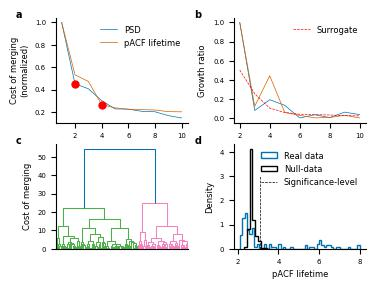

In [12]:
fig, axes = plt.subplots(figsize=(4, 3), ncols=2, nrows=2, dpi=100, gridspec_kw={'wspace': 0.35})

axes[0,0].plot(np.arange(1,11), psd_cost/psd_cost[0], label='PSD', color=ripples_blue, lw=0.5)
axes[0,0].plot(np.arange(1,11), pacf_cost/pacf_cost[0], label='pACF lifetime', color=ripples_orange, lw=0.5)

axes[0,0].scatter([2],[psd_cost[1]/psd_cost[0]], color='red', s=25, zorder=5)
axes[0,0].scatter([4],[pacf_cost[3]/pacf_cost[0]], color='red', s=25, zorder=5)

axes[0,1].plot(range(2,11), psd_gain/psd_gain[0], color=ripples_blue, lw=0.5)
axes[0,1].plot(range(2,11), pacf_gain/pacf_gain[0], color=ripples_orange, lw=0.5)
axes[0,1].plot(range(2,11), surr_gain_level, color='red', ls='--', label='Surrogate', lw=0.5)

sp.cluster.hierarchy.set_link_color_palette(CB_color_cycle[2:])
with plt.rc_context({'lines.linewidth': 0.75}):
    dend_data = sp.cluster.hierarchy.dendrogram(M_psds, no_labels=True, ax=axes[1,0])


axes[1,1].hist(subject_to_plot[fidx], bins=50, histtype='step', lw=1, label='Real data', density=True)
axes[1,1].hist(all_noise_lengths[fidx], bins=10, histtype='step', color='black', lw=1, label='Null-data', density=True)
axes[1,1].vlines(noise_level[fidx], 0, 3.0, color='black', lw=0.5, ls='--', label='Significance-level')

axes[0,0].legend(fontsize=6, frameon=False)
axes[0,1].legend(fontsize=6, frameon=False)

axes[0,0].set_xlabel('Number of clusters', fontsize=6)
axes[0,0].set_ylabel('Cost of merging\n(normalized)', fontsize=6)

axes[0,1].set_xlabel('Number of clusters', fontsize=6)
axes[0,1].set_ylabel('Growth ratio', fontsize=6)

axes[1,0].set_ylabel('Cost of merging', fontsize=6)
axes[0,1].set_xlabel('Contact', fontsize=6)

axes[1,1].legend(frameon=False, fontsize=6)
axes[1,1].set_xlabel('pACF lifetime', fontsize=6)
axes[1,1].set_ylabel('Density', fontsize=6)

for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(axis='both', labelsize=5.0)
    
for ax, label in zip(axes.flatten(), 'abcd'):
    ax.text(-0.3, 1, label, transform=ax.transAxes, fontsize=7, weight='bold')
    
fig.savefig('publication_figures/figure_2_supp.png', dpi=300, bbox_inches="tight")